In [1]:
import pandas as pd
from functools import partial
from multiprocessing import Pool, cpu_count
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.6)

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve


def fasta_reader(file):
    '''Converts .fasta to a pandas dataframe with accession as index
    and Protein in a column 'Protein'
    '''
    fasta_df = pd.read_csv(file, sep='>', lineterminator='>', header=None,\
                          )
    fasta_df[['Accession', 'Protein']] = fasta_df[0].str.split('\n', 1, \
                                        expand=True)

    fasta_df['Accession'] = fasta_df['Accession']
    fasta_df['Protein'] = fasta_df['Protein'].replace('\n', '', regex=True).\
                            astype(str).str.upper().replace('U', 'T')
    total_seq = fasta_df.shape[0]
    fasta_df.drop(0, axis=1, inplace=True)

    fasta_df = fasta_df[fasta_df.Protein != '']
    fasta_df = fasta_df[fasta_df.Protein != 'NONE']
    final_df = fasta_df.dropna()
    remained_seq = final_df.shape[0]
    if total_seq != remained_seq:
        warnings.warn("{} Proteins were removed due to inconsistencies in"
                      "provided file.".format(total_seq-remained_seq))
    return final_df

def progress(iteration, total, message=None):
    '''Simple progressbar
    '''
    if message is None:
        message = ''
    bars_string = int(float(iteration) / float(total) * 50.)
    print("\r|%-50s| %d%% (%s/%s) %s "% ('█'*bars_string+ "░" * \
                                     (50 - bars_string), float(iteration)/\
                                     float(total) * 100, iteration, total, \
                                     message), end='\r', flush=True)

    if iteration == total:
        print('\nCompleted!')

def predict(obj):
    res = obj.predict()
    try:
        f = obj.fungi()
    except Exception:
        f = ['Not a Signal peptide']
        
    try:
        t = obj.toxin()
    except Exception:
        t = ['Not a Signal peptide']
    
    c_score = obj.c_scores
    y = obj.y_scores
    cs = obj.cleavage_sites
    
    return [y.tolist()] + [c_score.tolist()] + [cs.tolist()] + res +  f + t


import time
import warnings
warnings.filterwarnings("ignore")

from razor import RAZOR

In [2]:
rev_df_ = pd.read_pickle('../results/new_uniprot.pkl.gz')
rev_df = rev_df_[~rev_df_.Sequence.str[:75].str.contains('B|J|O|X|Z')].copy()

In [3]:
tt = RAZOR(rev_df.Sequence[0], 60)
tt.predict()

[array([ True,  True,  True,  True,  True]),
 0.9086253353280438,
 0.88,
 array([23, 23])]

In [4]:
def cleavage(x):
    try:
        return int(x.split('..')[1].split(';')[0])
    except Exception:
        if str(x) != 'nan':
            print(x)
        return np.nan

rev_df['Cleav'] = rev_df['Signal peptide'].apply(cleavage)

In [5]:
rev_df.Label.value_counts()

0    52055
1      287
Name: Label, dtype: int64

In [6]:
seqs_obj = [RAZOR(x, 60) for x in rev_df.Sequence]

In [7]:

start_time = time.time()
pools = Pool(cpu_count()//2)
results = []
for res in pools.imap(predict, seqs_obj):
    results.append(res)
    progress(len(results), len(seqs_obj))
pools.close()
pools.join()
print("--- %s seconds --- for %d sequences.\n %f sequences per second"%(time.time() - start_time, rev_df.shape[0], \
                                             rev_df.shape[0]/(time.time() - start_time)))


In [8]:
rev_df['Preds'] = results

In [9]:
cols = ['All Y', 'C_scores', 'Cleavage_sites', 'SP', 'Median_Y', 'Median_C', 'Median_Cleavage',\
        'Fungi_Preds', 'Fungi_prob', 'Toxin_Preds', 'Toxin_prob']


rev_df[cols] = pd.DataFrame(rev_df.Preds.tolist(), index= rev_df.index)

In [10]:
rev_df.head(2)

In [11]:
rev_df.to_pickle('uniprot_new_seqs_threshold_0_57.pkl.gz')

In [12]:
rev_df = pd.read_pickle('uniprot_new_seqs_threshold_0_57.pkl.gz')

### Toxin

In [13]:
new_sp_toxins = pd.read_csv('uniprot-reviewed yes+keyword Signal+[KW-0732].tab.gz', sep='\t')
new_sp_toxins = new_sp_toxins[new_sp_toxins['Signal peptide'].apply(lambda x: '00269' in str(x))].copy()


In [14]:
new_sp_toxins[new_sp_toxins.Entry == 'P0DPU0']

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Signal peptide,Keywords,Taxonomic lineage (all)
8070,P0DPU0,VA552_SCODE,reviewed,Scoloptoxin SSD552 (Cysteine-rich venom protei...,NaN,Scolopendra dehaani (Thai centipede) (Scolopen...,210,"SIGNAL 1..23; /evidence=""ECO:0000269|PubMed:2...",Direct protein sequencing;Disulfide bond;Secre...,"cellular organisms, Eukaryota, Opisthokonta, M..."


In [15]:
tox_df_ = rev_df[rev_df['Entry'].apply(lambda x: x in new_sp_toxins.Entry.values)].copy()

# tox_df_['Label'] = tox_df_[tox_df_['Keywords'].apply(lambda x: 'toxin' in str(x).lower())].copy()

In [16]:
keywords = pd.read_csv('keywords_uniprot-yourlist M20210217A94466D2655679D1FD8953E075198DA8025AA6P.tab.gz', sep='\t')


tox_df = pd.merge(tox_df_, keywords[['Entry', 'Keywords']])

tox_df['Toxin'] = tox_df['Keywords'].apply(lambda x: 1 if 'toxin' in str(x).lower() else 0)



#Remove training seqs
train = pd.read_pickle('../results/toxin_nontoxin.pkl.gz')

tox_df = tox_df[tox_df.Entry.apply(lambda x: x not in train.Entry.values)]

In [17]:
tox_df.loc[11, 'Toxin'] = 1 #Scoloptoxin but didnt have toxin keyword
tox_df.loc[17, 'Toxin'] = 1 # ''

tox_df['Toxin'].value_counts()

0    194
1     47
Name: Toxin, dtype: int64

In [75]:
194 + 47

241

In [18]:
tox_df['Median_Toxin'] = tox_df['Toxin_prob'].apply(lambda x: np.median(x) if x is not None else x)

MCC = 0.7681325498075513


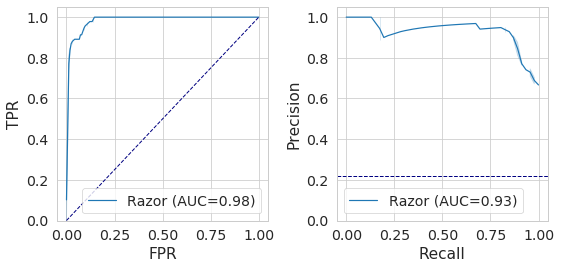

In [21]:
cols = ['Median_Toxin']
names = ['Razor', ]


new = tox_df[~tox_df['Median_Toxin'].isna()].copy()
# new['Final_Predicted_Class'] = new['?'].apply(lambda x: 1 if x == 'Y' else 0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),)

for i, v in enumerate(cols):

    preds = new[v]
    y = new['Toxin']

    #Precision, recall
    precision, recall, _ = precision_recall_curve(y, preds, )
    lr_auc = auc(recall, precision)


    #ROC

    fpr, tpr, _ = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)





    sns.lineplot(x=fpr, y=tpr, label='{} (AUC={})'.format(names[i], round(roc_auc, 2)), ax=ax[0])
    #baseline
    ax[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

    sns.lineplot(x=recall, y=precision, label='{} (AUC={})'.format(names[i], round(lr_auc, 2)), ax=ax[1])
    #baseline
    baseline = new.Toxin.value_counts()[1]/new.shape[0]

    ax[1].axhline(y=baseline, color='navy', lw=1, linestyle='--')
    ax[0].set_xlabel('FPR')
    ax[0].set_ylabel('TPR')
    ax[0].set_ylim([0, 1.05])


    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_ylim([0, 1.05])


fig.tight_layout()
print('MCC = {}'.format(matthews_corrcoef(y, new['Median_Toxin'].apply(lambda x: 1 if x >= 0.33  else 0))))
plt.savefig('../figs/Benchmark_Toxins_new_data.pdf', bbox_inches='tight', pad_inches=0);

##### false positives are mostly defensive proteins

In [22]:
false = tox_df[tox_df["Toxin"] == 0]
false[false['Median_Toxin'] >= 0.33]

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Sequence,Signal peptide,Protein existence,...,Median_Y,Median_C,Median_Cleavage,Fungi_Preds,Fungi_prob,Toxin_Preds,Toxin_prob,Keywords,Toxin,Median_Toxin
21,A2SY66,VICHY_VICSN,reviewed,Vicianin hydrolase (VH) (EC 3.2.1.119) (Fragment),NaN,Vicia sativa subsp. nigra (Common vetch) (Vici...,509,ISPSLLYLFSLATLLAVVTGTGTPSQEVHPSHYATTFNKSLFPKDF...,"SIGNAL <1..19; /evidence=""ECO:0000269|PubMed:...",Evidence at protein level,...,0.877952,0.82,[20],"[False, False, False, False, False]","[0.15, 0.2, 0.19, 0.13, 0.15]","[False, True, True, True, False]","[0.26, 0.4, 0.39, 0.39, 0.24]",Direct protein sequencing;Disulfide bond;Glyco...,0,0.39
33,P01301,PAHO_SHEEP,reviewed,Pancreatic prohormone (Pancreatic polypeptide)...,PPY,Ovis aries (Sheep),78,LLLSTCVALLLQPPLGALGASLEPEYPGDNATPEQMAQYAAELRRY...,"SIGNAL <1..19; /evidence=""ECO:0000269|Ref.2""",Evidence at protein level,...,0.617495,0.92,[19],"[False, False, False, False, False]","[0.0, 0.0, 0.0, 0.01, 0.0]","[False, True, True, True, False]","[0.29, 0.47, 0.45, 0.39, 0.25]",Amidation;Cleavage on pair of basic residues;D...,0,0.39
60,B3EWP3,DEF1_ARAHY,reviewed,Defensin 1 (allergen Ara h 12) (Fragment),NaN,Arachis hypogaea (Peanut),71,KTVAGFCIFFLVLFLAQEGVVKTEAKLCNHLADTYRGPCFTNASCD...,"SIGNAL <1..25; /evidence=""ECO:0000269|PubMed:...",Evidence at protein level,...,0.794040,0.65,[23],"[False, False, False, False, False]","[0.03, 0.02, 0.04, 0.01, 0.0]","[True, False, True, False, True]","[0.41, 0.31, 0.41, 0.33, 0.34]",Allergen;Antimicrobial;Defensin;Direct protein...,0,0.34
77,A0AT33,NLTP4_LENCU,reviewed,Non-specific lipid-transfer protein 4 (LTP4) [...,NaN,Lens culinaris (Lentil) (Cicer lens),110,CVVLVMCMVVIAPMAEGAISCGAVTSDLSPCLTYLTGGPGPSPQCC...,"SIGNAL <1..17; /evidence=""ECO:0000269|PubMed:...",Evidence at protein level,...,0.861684,0.98,[17],"[False, False, False, False, False]","[0.0, 0.0, 0.01, 0.0, 0.0]","[False, True, True, True, False]","[0.25, 0.4, 0.41, 0.38, 0.3]",Direct protein sequencing;Disulfide bond;Lipid...,0,0.38
115,P67876,RNMG_ASPRE,reviewed,Ribonuclease mitogillin (EC 3.1.27.-) (Restric...,ret,Aspergillus restrictus,176,MVAIKNLFLLAATAVSVLAAPSPLDARATWTCINQQLNPKTNKWED...,"SIGNAL 1..27; /evidence=""ECO:0000269|PubMed:3...",Evidence at protein level,...,0.894874,0.86,[19],"[True, True, True, True, True]","[0.67, 0.44, 0.51, 0.56, 0.51]","[False, True, True, True, True]","[0.0, 0.65, 0.67, 0.65, 0.65]",3D-structure;Direct protein sequencing;Disulfi...,0,0.65
120,C0HKC3,PA2B1_AGKPL,reviewed,Basic phospholipase A2 APL-D49 (svPLA2) (EC 3....,NaN,Agkistrodon piscivorus leucostoma (Western cot...,139,MRTLWIMAVLLLGVEGNLFQFEKLIKKMTGKSGMLWYSAYGCYCGW...,"SIGNAL 1..16; /evidence=""ECO:0000269|PubMed:2...",Evidence at protein level,...,1.000000,1.00,"[16, 16, 16, 16]","[False, False, False, False, False]","[0.0, 0.0, 0.0, 0.0, 0.01]","[True, True, True, True, True]","[0.98, 0.92, 0.95, 1.0, 0.96]",Calcium;Direct protein sequencing;Disulfide bo...,0,0.96
133,P22324,A1AF_CAVPO,reviewed,Alpha-1-antiproteinase F (APF) (Alpha-1-antitr...,NaN,Cavia porcellus (Guinea pig),403,SAIPRGLLLLAGLCCLVFGIMAEDAQVAQGPSQQIPRSLAHFAHSM...,"SIGNAL <1..22; /evidence=""ECO:0000269|PubMed:...",Evidence at protein level,...,0.944669,0.96,[19],"[False, False, False, False, False]","[0.0, 0.0, 0.0, 0.0, 0.0]","[True, True, True, False, True]","[0.44, 0.34, 0.42, 0.27, 0.36]",Acute phase;Direct protein sequencing;Glycopro...,0,0.36
144,P52307,5NTD_RHIMP,reviewed,Protein 5NUC [Includes: UDP-sugar hydrolase (E...,NaN,Rhipicephalus microplus (Cattle tick) (Boophil...,580,GRLLACLLLPGLAATDFTATVLHTNDVHGRFEQITASGTRCTKQAA...,"SIGNAL <1..14; /evidence=""ECO:0000269|PubMed:...",Evidence at protein level,...,0.727461,0.63,"[15, 15]","[False, False, False, False, False]","[0.03, 0.05, 0.07, 0.05, 0.06]","[True, False, True, False, False]","[0.44, 0.33, 0.41, 0.3, 0.29]",Cell membrane;Direct protein sequencing;Disulf...,0,0.33
150,P25403,AMP1_MIRJA,reviewed,Anti

In [23]:
tox_df[['Entry', 'Sequence', 'Signal peptide', 'Toxin']].reset_index(drop=True).to_csv('../results/benchmark_toxins.csv.gz',\
                                                                                      index=None)

#### Toxin benchmark including eukaryotic classifier

In [57]:
rev_df['Median_Toxin'] = rev_df['Toxin_prob'].apply(lambda x: np.median(x) if x is not None else x)

#Remove training seqs
train = pd.read_pickle('../results/toxin_nontoxin.pkl.gz')

rev_df_tox = rev_df[rev_df['Entry'].apply(lambda x: x not in train.Entry.values)]

rev_df_tox['Toxin_Label'] = rev_df_tox['Entry'].apply(lambda x: 1 if x in tox_df[tox_df['Toxin'] == 1]['Entry'].values else 0)

In [58]:
rev_df_tox['Toxin_Label'].value_counts()

0    52249
1       47
Name: Toxin_Label, dtype: int64

In [80]:
# rev_df_tox['Toxin_Label']
rev_df_tox['Preds_razor'] = rev_df_tox['Median_Toxin'].apply(lambda x: 1 if x >= 0.33  else 0)

rev_df_tox.to_pickle('toxins_scored-razor.pkl.gz')

### Also export seqs to benchmark other tools 

In [82]:
export = rev_df[['Entry', 'Sequence']].copy()
export['Entry'] = '>' + export['Entry']

export.to_csv('../results/new_uniprot.fa', header=None, sep='\n', index=None)

In [125]:
! cd ~/Documents/Signal/signalp-4.1/ && ./signalp ~/Documents/Signal/results/new_uniprot.fa > ~/Documents/SigMan/results/new_uniprot.fa.signalp4


In [128]:
! cd ~/Documents/Signal/Human/signalp-5.0b/bin && ./signalp -batch 10000 -fasta ~/Documents/Signal/results/new_uniprot.fa -org euk -format short -prefix euk_10_long

SignalP-5.0. Starting fasta file reading...
Total proteins read: 52342.
Organism: euk.
Starting protein prediction...
Temporary directory: /tmp/signalp5.500227382
Protein prediction done!
Generating output files...
Completed.


#### DeepSig results

In [338]:
ds = pd.read_csv('../results/new_uniprot.deepsig', sep='\t', header=None)
ds = ds.drop_duplicates(0)
ds.columns = ['Entry', 'Tool', 'Result', 3, 'Cleavage_DeepSig', 'Prob_DeepSig', 6, 7, 8]
ds['Prob_DeepSig'] = ds['Prob_DeepSig'].astype(float, errors='ignore').apply(lambda x: 0 if x == '.' else x)
ds

,Entry,Tool,Result,3,Cleavage_DeepSig,Prob_DeepSig,6,7,8
0,P0DQE1,DeepSig,Signal peptide,1,23,0.91,.,.,evidence=ECO:0000256
2,P0DPZ2,DeepSig,Signal peptide,1,23,0.93,.,.,evidence=ECO:0000256
4,P0DPV6,DeepSig,Signal peptide,1,23,0.98,.,.,evidence=ECO:0000256
6,P0DPU6,DeepSig,Chain,1,197,0,.,.,evidence=ECO:0000256
7,P19438,DeepSig,Signal peptide,1,24,0.98,.,.,evidence=ECO:0000256
...,...,...,...,...,...,...,...,...,...
52978,Q8IVQ6,DeepSig,Chain,1,265,0,.,.,evidence=ECO:0000256
52979,O48626,DeepSig,Chain,1,742,0,.,.,evidence=ECO:0000256
52980,P45972,DeepSig,Chain,1,705,0,.,.,evidence=ECO:0000256
52981,Q62394,DeepSig,Chain,1,352,0,.,.,evidence=ECO:0000256
